In [73]:

#Phase 2: Analysis of Historical SPEI for Maranhão (2000–2024)
#SPEI is computed by:
# 1. calculating the climatic water balance D=P−PET,
# 2. transforming the cumulative probability to a standardized normal variable.


#A Multiscalar Drought Index Sensitive to Global Warming: The Standardized Precipitation Evapotranspiration Index
#Sergio M. Vicente-Serrano

###### 1. Data Aqcquisition  

#From ERA5:

#Total precipitation 

import xarray as xr

ds2 = xr.open_dataset("Precip_ERA5_20002024.nc")
#ds2

#Wind
#10m u- Component of wind
ds3 = xr.open_dataset("Wind10mu_ERA5_20002024.nc")
#ds3

#10m v- Component of wind
ds4 = xr.open_dataset("Wind10mv_ERA5_20002024.nc")
#ds4

#Radiation
#Surface Solar Radiation Downwards

ds5 = xr.open_dataset("SSRadiation_ERA5_20002024.nc")
#ds5

#Surface thermal Radiation Downwards

ds6 = xr.open_dataset("STRadiation_ERA5_20002024.nc")
#ds6


#Temperature 
#2m temperature

ds7 = xr.open_dataset("2mTemperature_ERA5_20002024.nc")
#ds7

#2 m dwpoint temperature

ds8 = xr.open_dataset("2mDWPoint_ERA5_20002024.nc")
ds8



<xarray.Dataset>
Dimensions:     (latitude: 141, longitude: 101, valid_time: 300)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2000-01-01 2000-02-01 ... 2024-12-01
  * latitude    (latitude) float64 3.0 2.9 2.8 2.7 ... -10.7 -10.8 -10.9 -11.0
  * longitude   (longitude) float64 -50.0 -49.9 -49.8 ... -40.2 -40.1 -40.0
Data variables:
    number      int64 ...
    expver      (valid_time) object ...
    d2m         (valid_time, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-11-30T23:02 GRIB to CDM+CF via cfgrib-0.9.1...

In [74]:

###### 2. Merge to create a a Dataset of all variables
import xarray as xr

# Precipitation
precip = xr.open_dataset("Precip_ERA5_20002024.nc")

# Wind
u10 = xr.open_dataset("Wind10mu_ERA5_20002024.nc")
v10 = xr.open_dataset("Wind10mv_ERA5_20002024.nc")

# Radiation
ssrd = xr.open_dataset("SSRadiation_ERA5_20002024.nc")
strd = xr.open_dataset("STRadiation_ERA5_20002024.nc")

# Temperature
t2m = xr.open_dataset("2mTemperature_ERA5_20002024.nc")
d2m = xr.open_dataset("2mDWPoint_ERA5_20002024.nc")


# Merge into 1 Dataset
ds = xr.merge([
    precip.rename({"tp": "precip"}),
    u10.rename({"u10": "u"}),
    v10.rename({"v10": "v"}),
    ssrd.rename({"ssrd": "rs_down"}),
    #strd.rename({"ssrd": "rl_down"}), #Data is the same as ssrd
    t2m.rename({"t2m": "tair"}),
    d2m.rename({"d2m": "tdew"})
])

ds

<xarray.Dataset>
Dimensions:     (latitude: 141, longitude: 101, valid_time: 300)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2000-01-01 2000-02-01 ... 2024-12-01
  * latitude    (latitude) float64 3.0 2.9 2.8 2.7 ... -10.7 -10.8 -10.9 -11.0
  * longitude   (longitude) float64 -50.0 -49.9 -49.8 ... -40.2 -40.1 -40.0
Data variables:
    number      int64 0
    expver      (valid_time) object '0001' '0001' '0001' ... '0001' '0001'
    precip      (valid_time, latitude, longitude) float32 ...
    u           (valid_time, latitude, longitude) float32 ...
    v           (valid_time, latitude, longitude) float32 ...
    rs_down     (valid_time, latitude, longitude) float32 ...
    tair        (valid_time, latitude, longitude) float32 ...
    tdew        (valid_time, latitude, longitude) float32 ...

In [75]:
#2. Transformation of Units of all variables

import numpy as np


############### Temperature
#From kelvin to Celsius
ds["tair"] = ds["tair"] - 273.15
ds["tdew"] = ds["tdew"] - 273.15



############### Radiation

# Solar radiation from 
# seconds per month
seconds_per_month = ds.valid_time.dt.days_in_month * 24 * 3600

#  J/m2 to W/m2
ds["rs_down"] = ds["rs_down"] / seconds_per_month

# J/m2 to MJ/m2/day
ds["Rs"] = ds["rs_down"] * 86400 / 1e6

################ Precipitation 

#From meters to mm
ds["precip"] = ds["precip"] * 1000



############# Transform wind 
#FAO-56 uses a speed at 2m, but ERA5 uses a speed at 10m.


u10 = ds["u"]
v10 = ds["v"]

# Wind velocity to 10 m
wind10 = np.sqrt(u10**2 + v10**2)

# transform to equivalent velocity 2m (FAO-56)
wind2 = wind10 * 4.87 / np.log(67.8 * 10 - 5.42)

ds["wind2"] = wind2





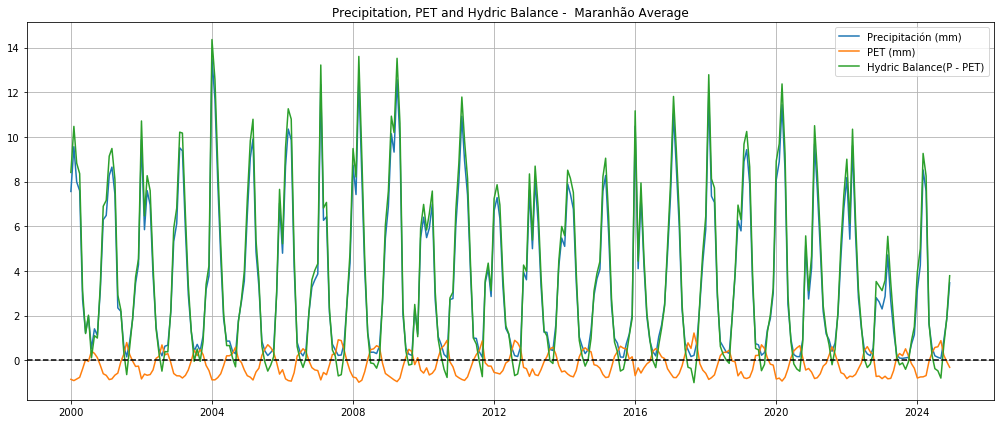

In [76]:
#3. Calculate vapor pressure (FAO-56)

def es(T):
    return 0.6108 * np.exp((17.27 * T) / (T + 237.3))

ds["es"] = es(ds["tair"])
ds["ea"] = es(ds["tdew"])


#4. Calculate the slope of the vapor pressure curve

ds["delta"] = (4098 * ds["es"]) / ( (ds["tair"] + 237.3)**2 )

#5. Physcrometric constant gamma

gamma = 0.066

#6.Net Radiation FAO 56

albedo = 0.23
ds["Rns"] = (1 - albedo) * ds["Rs"]

# approximate Rnl using Tmean
sigma = 4.903e-9
T_K = ds["tair"] + 273.15
ds["Rnl"] = sigma * (T_K**4) * (0.34 - 0.14 * np.sqrt(ds["ea"])) * (1.35 - 0.35)

#7. Total Net Radiation


ds["Rn"] = ds["Rns"] - ds["Rnl"]


#8. Calculation of PET FAO 56
PET = ( 0.408 * ds["delta"] * ds["Rn"] + gamma * (900 / (ds["tair"] + 273)) * ds["wind2"] * (ds["es"] - ds["ea"])) / (   ds["delta"] + gamma * (1 + 0.34 * ds["wind2"]))

ds["PET"] = PET

#9. Hydric balance

ds["D"] = ds["precip"] - ds["PET"]

#10. Plots of Hydric Balance of Maranhao


import matplotlib.pyplot as plt

P = ds["precip"].mean(dim=["latitude", "longitude"]).to_pandas()
PET = ds["PET"].mean(dim=["latitude", "longitude"]).to_pandas()
D = ds["D"].mean(dim=["latitude", "longitude"]).to_pandas()

plt.figure(figsize=(14,6))
plt.plot(P, label="Precipitación (mm)")
plt.plot(PET, label="PET (mm)")
plt.plot(D, label="Hydric Balance(P - PET)")
plt.axhline(0, color="k", linestyle="--")
plt.title("Precipitation, PET and Hydric Balance -  Maranhão Average")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

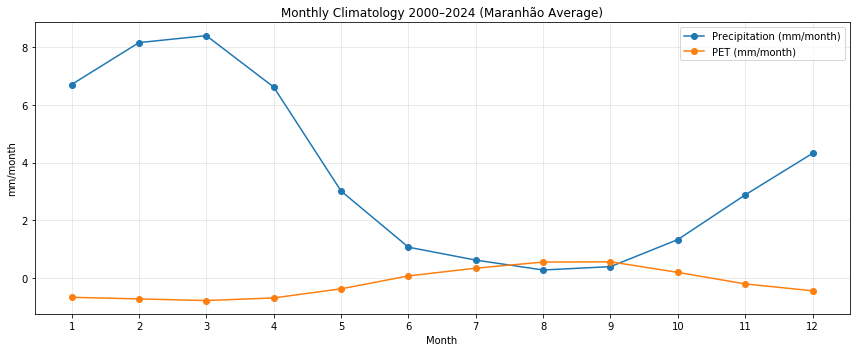

In [77]:
import matplotlib.pyplot as plt

# Monthly climatological precipitation

P_clim = ds["precip"].mean(dim=["latitude", "longitude"]).groupby("valid_time.month").mean().to_pandas()

# Monthly climatological PET
PET_clim = ds["PET"].mean(dim=["latitude", "longitude"]).groupby("valid_time.month").mean().to_pandas()

plt.figure(figsize=(12,5))
plt.plot(P_clim.index, P_clim.values, marker="o", label="Precipitation (mm/month)")
plt.plot(PET_clim.index, PET_clim.values, marker="o", label="PET (mm/month)")

plt.xticks(range(1,13))
plt.title("Monthly Climatology 2000–2024 (Maranhão Average)")
plt.xlabel("Month")
plt.ylabel("mm/month")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [78]:
import geopandas as gpd

shp = gpd.read_file("maranhao_boundary.shp")
shp

,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry
0,BRA.10_1,BRA,Brazil,Maranhão,São Luíz de Maranhão,NA,Estado,State,NA,BR.MA,NA,(POLYGON ((-45.54022580499998 -7.8625311869999...


In [58]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

#Re order Latitud
D_raw = ds["D"].mean(dim="valid_time")
#D_raw = ds["D"].sel(valid_time=slice("2015-01-01", "2015-12-31"))

lat = ds.latitude.values
lon = ds.longitude.values

# Invert 
if lat[0] > lat[-1]:
    lat = lat[::-1]
    D_raw = D_raw[::-1, :]

# Extent
extent = [lon.min(), lon.max(), lat.min(), lat.max()]

##############################Plot 
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.PlateCarree())

# plot raster by hand
img = ax.imshow(
    D_raw,
    extent=extent,
    origin="lower",
    transform=ccrs.PlateCarree(),
    cmap="BrBG"
)

# colorbar 
cbar = plt.colorbar(img, ax=ax, shrink=0.7)
cbar.set_label("Hydric Balance (mm/month)")

# shapefile
for geom in shp.geometry:
    ax.add_geometries(
        [geom],
        crs=ccrs.PlateCarree(),
        facecolor='none',
        edgecolor='black',
        linewidth=1.2
    )

ax.set_title("Hydric Balance Maranhão")
ax.coastlines()
plt.show()

NameError: name 'ds' is not defined

In [80]:
import geopandas as gpd

shp = gpd.read_file("maranhao_boundary.shp")
shp

,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry
0,BRA.10_1,BRA,Brazil,Maranhão,São Luíz de Maranhão,NA,Estado,State,NA,BR.MA,NA,(POLYGON ((-45.54022580499998 -7.8625311869999...


In [81]:
shp.crs
shp.total_bounds

array([-48.75515074, -10.2617647 , -41.79606907,  -1.04932812])

In [19]:
ds.longitude.min().values, ds.longitude.max().values, ds.latitude.min().values, ds.latitude.max().values


(array(-50.), array(-40.), array(-11.), array(3.))

In [20]:
D_mean = ds["D"].mean(dim="valid_time")

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [21]:
D_mean.to_netcdf("D_mean_2D.nc")

In [22]:
import xarray as xr

ds2 = xr.open_dataset("D_mean_2D.nc")
ds2["latitude"].attrs["units"] = "degrees_north"
ds2["longitude"].attrs["units"] = "degrees_east"
ds2.attrs["crs"] = "EPSG:4326"

ds2.to_netcdf("D_mean_2D_fixed.nc")


In [23]:
!gdalwarp \
    -s_srs EPSG:4326 \
    -t_srs EPSG:4326 \
    -cutline maranhao_fixed.shp \
    -crop_to_cutline \
    -dstalpha \
    -overwrite \
    D_mean_2D_fixed.nc \
    D_clipped.tif

Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Creating output file that is 69P x 92L.
Processing D_mean_2D_fixed.nc [1/1] : 0Using internal nodata values (e.g. nan) for image D_mean_2D_fixed.nc.
...10...20...30...40...50...60...70...80...90...100 - done.


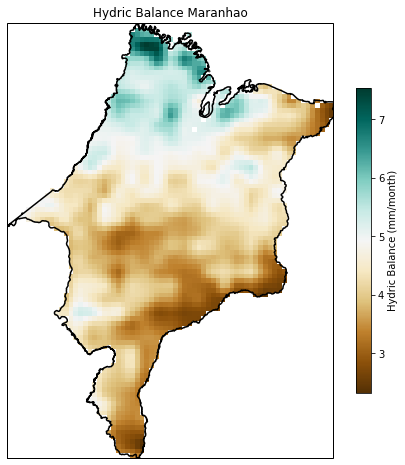

In [24]:
import rasterio
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd

# Raster
src = rasterio.open("D_clipped.tif")
D = src.read(1)

# Extent
bounds = src.bounds
extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

# Shapefile
shp = gpd.read_file("maranhao_fixed.shp")

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())

D = D.astype(float)
D[D == 0] = np.nan

im = ax.imshow(
    D,
    extent=extent,
    cmap="BrBG",
    origin="upper",
    transform=ccrs.PlateCarree()
)

# Boundary
for geom in shp.geometry:
    ax.add_geometries(
        [geom],
        crs=ccrs.PlateCarree(),
        facecolor='none',
        edgecolor='black',
        linewidth=1.5
    )

plt.colorbar(im, ax=ax, shrink=0.7, label="Hydric Balance (mm/month)")
ax.set_title("Hydric Balance Maranhao")
plt.show()

In [25]:
###############################
#SPEI1
#Ahmad et al. (1988): L-moment estimation of log-logistic
#Singh et al. (1993): Pearson III  log-logístic equivalent
#Vicente-Serrano et al. (2010): SPEI
ds["D"]


<xarray.DataArray 'D' (valid_time: 300, latitude: 141, longitude: 101)>
array([[[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [11.903221, 12.131972, ...,  3.010524,  2.872576],
        [12.00093 , 12.014703, ...,  2.992259,  2.769915]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [11.078851, 10.550398, ...,  3.831413,  3.975298],
        [10.879359, 10.346703, ...,  3.775103,  3.623038]],

       ...,

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [ 7.822277,  7.126238, ...,  0.818898,  0.684756],
        [ 7.463437,  6.876941, ...,  0.96129 ,  0.721616]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [12.174001, 10.556215, 

In [26]:
D1 = ds["D"]
D1

<xarray.DataArray 'D' (valid_time: 300, latitude: 141, longitude: 101)>
array([[[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [11.903221, 12.131972, ...,  3.010524,  2.872576],
        [12.00093 , 12.014703, ...,  2.992259,  2.769915]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [11.078851, 10.550398, ...,  3.831413,  3.975298],
        [10.879359, 10.346703, ...,  3.775103,  3.623038]],

       ...,

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [ 7.822277,  7.126238, ...,  0.818898,  0.684756],
        [ 7.463437,  6.876941, ...,  0.96129 ,  0.721616]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [12.174001, 10.556215, 

In [27]:
print(ds["D"])
print(ds["D"].shape)
print(np.isnan(ds["D"].values).all())
print(ds["D"].isel(valid_time=0))

<xarray.DataArray 'D' (valid_time: 300, latitude: 141, longitude: 101)>
array([[[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [11.903221, 12.131972, ...,  3.010524,  2.872576],
        [12.00093 , 12.014703, ...,  2.992259,  2.769915]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [11.078851, 10.550398, ...,  3.831413,  3.975298],
        [10.879359, 10.346703, ...,  3.775103,  3.623038]],

       ...,

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [ 7.822277,  7.126238, ...,  0.818898,  0.684756],
        [ 7.463437,  6.876941, ...,  0.96129 ,  0.721616]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [12.174001, 10.556215, 

In [28]:
ds = ds.sortby("valid_time")
ds

<xarray.Dataset>
Dimensions:     (latitude: 141, longitude: 101, valid_time: 300)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2000-01-01 2000-02-01 ... 2024-12-01
  * latitude    (latitude) float64 3.0 2.9 2.8 2.7 ... -10.7 -10.8 -10.9 -11.0
  * longitude   (longitude) float64 -50.0 -49.9 -49.8 ... -40.2 -40.1 -40.0
Data variables:
    number      int64 0
    expver      (valid_time) object '0001' '0001' '0001' ... '0001' '0001'
    precip      (valid_time, latitude, longitude) float32 nan nan ... 0.12966202
    u           (valid_time, latitude, longitude) float32 nan nan ... -2.405817
    v           (valid_time, latitude, longitude) float32 nan nan ... 0.9597807
    rs_down     (valid_time, latitude, longitude) float64 nan nan ... 9.325
    tair        (valid_time, latitude, longitude) float32 nan nan ... 28.391022
    tdew        (valid_time, latitude, longitude) float32 nan nan ... 16.291168
    Rs          (valid_time, latitude, longitude) float64 nan nan ... 0.8057


In [32]:
from scipy.stats import norm
import numpy as np

def spei1_series_by_month_empirical(ts, months, min_years=20):

    
###################For each month, values are ranked and transformed into standard normal variates using the Gringorten plotting position.
    
    out = np.full(ts.shape, np.nan, dtype=float)

    for m in range(1, 13):
        idx = np.where((months == m) & np.isfinite(ts))[0]
        if idx.size < min_years:
            continue

        x = ts[idx]

        
        # Rank the values in ascending order
        order = np.argsort(x)
        ranks = np.empty_like(order, dtype=float)
        ranks[order] = np.arange(1, len(x) + 1)

        # Gringorten plotting position
        F = (ranks - 0.44) / (len(x) + 0.12)
        # Avoid probabilities of exactly 0 or 1
        F = np.clip(F, 1e-6, 1 - 1e-6)

        out[idx] = norm.ppf(F)

    return out


###################################################
# Inputs
ds = ds.sortby("valid_time")
D1 = ds["D"]                      
time = D1["valid_time"]
months = time.dt.month.values     

Dvals = D1.values
ntime, nlat, nlon = Dvals.shape

print("D1 shape:", Dvals.shape)

# MASK : DATA WITH VALID 
valid_counts = np.isfinite(Dvals).sum(axis=0)   # (lat, lon)

min_valid_months = 240   
mask_pix = valid_counts >= min_valid_months

print("Pixels kept:", mask_pix.sum(), "out of", mask_pix.size)

#Statistics
if mask_pix.sum() > 0:
    print("Valid months:",
          valid_counts[mask_pix].min(),
          np.median(valid_counts[mask_pix]),
          valid_counts[mask_pix].max())


spei1_array = np.full((ntime, nlat, nlon), np.nan, dtype="float32")

############################################
Dflat = Dvals.reshape(ntime, -1)
Sflat = spei1_array.reshape(ntime, -1)

## Indices of pixels that meet the minimum data availability criterion
idx_pix = np.where(mask_pix.ravel())[0]

#O ver valid pixels: 
for j in idx_pix:
    ts = Dflat[:, j]
    
#Compute SPEI1 
    Sflat[:, j] = spei1_series_by_month_empirical(ts, months, min_years=20)

###############################################
#X array
spei1_emp = xr.DataArray( spei1_array, coords=D1.coords, dims=D1.dims, name="SPEI1_empirical_byMonth")

print(spei1_emp)


###############################################
spei1_emp.to_netcdf("SPEI1_empirical_byMonth.nc",encoding={"SPEI1_empirical_byMonth": {"dtype":"float32","zlib":True,"complevel":4,"_FillValue":-9999.0}})



D1 shape: (300, 141, 101)
Pixels kept: 9476 out of 14241
Valid months kept min/median/max: 300 300.0 300
<xarray.DataArray 'SPEI1_empirical_byMonth' (valid_time: 300, latitude: 141, longitude: 101)>
array([[[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [ 0.521655,  0.639815, ...,  0.639815,  0.639815],
        [ 0.521655,  0.521655, ...,  0.767684,  0.767684]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [ 0.200916,  0.200916, ...,  0.909555,  0.909555],
        [ 0.099952,  0.200916, ...,  0.909555,  0.909555]],

       ...,

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [-0.410378, -0.521655, ...,  0.099952,  0.      ],
        [-0.521655, -0.639815, ...,  0.200916,  0.      ]],

       [[      nan,       nan, ...,

In [33]:
spei_reg = spei1_emp.where(mask_pix).mean(dim=["latitude","longitude"], skipna=True)

idx_min = spei_reg.argmin("valid_time")
severe_date = spei_reg["valid_time"].isel(valid_time=idx_min).values

print("Most severe month (regional mean):", severe_date)
print("Regional min SPEI:", float(spei_reg.min()))

Most severe month (regional mean): 2023-02-01T00:00:00.000000000
Regional min SPEI: -1.6534050703048706


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


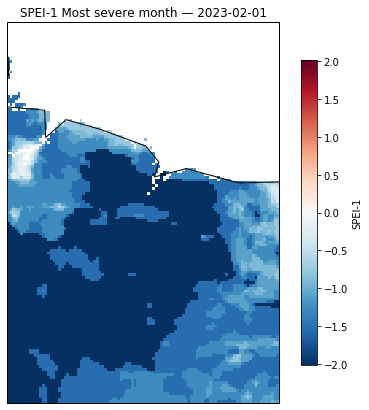

In [51]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

Smap = spei1_emp.sel(valid_time=severe_date).where(mask_pix)

lon = Smap.longitude.values
lat = Smap.latitude.values
extent = [lon.min(), lon.max(), lat.min(), lat.max()]

v = float(np.nanmax(np.abs(Smap.values)))
v = min(max(v, 2.0), 3.5)

fig = plt.figure(figsize=(8,7))
ax = plt.axes(projection=ccrs.PlateCarree())

img = ax.imshow(
    Smap.values,
    extent=extent,
    origin="upper" if lat[0] > lat[-1] else "lower",
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    vmin=-v, vmax=v
)

ax.coastlines()
ax.set_title(f"SPEI-1 Most severe month — {str(severe_date)[:10]}")
cbar = plt.colorbar(img, ax=ax, shrink=0.8)
cbar.set_label("SPEI-1")
plt.tight_layout()
plt.show()


In [48]:
print("Most severe drought month:", severe_date)
print("SPEI min/max:", float(SPEI_severe.min()), float(SPEI_severe.max()))

Most severe drought month: 2003-04-01T00:00:00.000000000
SPEI min/max that month: -2.9794535636901855 2.821706771850586


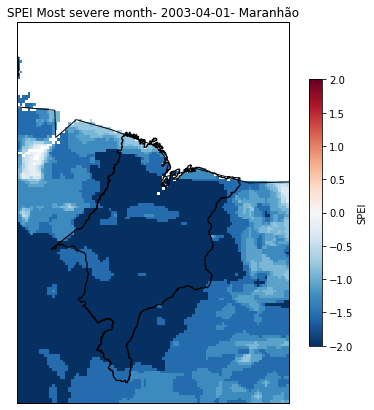

In [96]:

import geopandas as gpd

shp = gpd.read_file("maranhao_boundary.shp")
shp

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

#Re order Latitud
D_raw = ds["D"].mean(dim="valid_time")
lat = ds.latitude.values
lon = ds.longitude.values

# Invert 
if lat[0] > lat[-1]:
    lat = lat[::-1]
    D_raw = D_raw[::-1, :]
    Smap = Smap[::-1, :]

# Extent
extent = [lon.min(), lon.max(), lat.min(), lat.max()]

##############################Plot 
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.PlateCarree())

# plot raster by hand
img = ax.imshow(
    Smap,
    extent=extent,
    origin="lower",
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    vmin=-2,  
    vmax=2    
)

# colorbar 
cbar = plt.colorbar(img, ax=ax, shrink=0.7)
cbar.set_label("SPEI")

# shapefile
for geom in shp.geometry:
    ax.add_geometries(
        [geom],
        crs=ccrs.PlateCarree(),
        facecolor='none',
        edgecolor='black',
        linewidth=1.2
    )

ax.set_title("SPEI Most severe month- 2003-04-01- Maranhão")
ax.coastlines()
plt.show()

In [98]:
Smap.to_netcdf("Smap.nc")
import xarray as xr

Smap2 = xr.open_dataset("Smap.nc")
Smap2["latitude"].attrs["units"] = "degrees_north"
Smap2["longitude"].attrs["units"] = "degrees_east"
Smap2.attrs["crs"] = "EPSG:4326"

Smap2.to_netcdf("Smap2_fixed.nc")

!gdalwarp \
    -s_srs EPSG:4326 \
    -t_srs EPSG:4326 \
    -cutline maranhao_fixed.shp \
    -crop_to_cutline \
    -dstalpha \
    -overwrite \
    Smap2_fixed.nc \
    Smap2_fixed_clipped.tif

Warning 1: No UNIDATA NC_GLOBAL:Conventions attribute
Creating output file that is 69P x 92L.
Processing Smap2_fixed.nc [1/1] : 0Using internal nodata values (e.g. nan) for image Smap2_fixed.nc.
...10...20...30...40...50...60...70...80...90...100 - done.


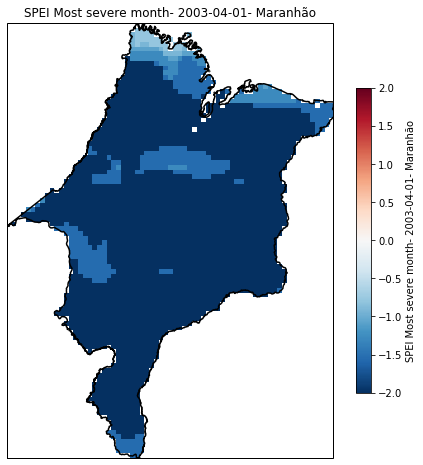

In [102]:
import rasterio
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd

# Raster
src = rasterio.open("Smap2_fixed_clipped.tif")
D = src.read(1)

# Extent
bounds = src.bounds
extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

# Shapefile
shp = gpd.read_file("maranhao_fixed.shp")

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())

D = D.astype(float)
D[D == 0] = np.nan

im = ax.imshow(
    D,
    extent=extent,
    cmap="RdBu_r",
    origin="upper",
    transform=ccrs.PlateCarree(),
    vmin=-2,  
    vmax=2    
)

# Boundary
for geom in shp.geometry:
    ax.add_geometries(
        [geom],
        crs=ccrs.PlateCarree(),
        facecolor='none',
        edgecolor='black',
        linewidth=1.5
    )

plt.colorbar(im, ax=ax, shrink=0.7, label="SPEI Most severe month- 2003-04-01- Maranhão")
ax.set_title("SPEI Most severe month- 2003-04-01- Maranhão")
plt.show()

SPEI promedio 2015: -0.500


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


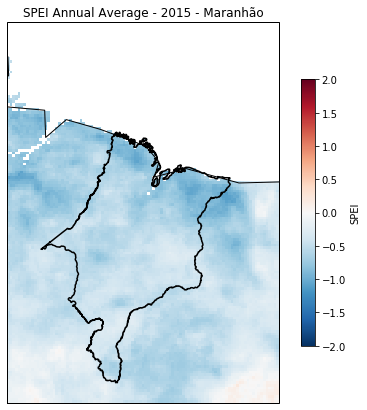

In [110]:
Smap_2015 = spei1_emp.sel(valid_time='2015').mean(dim='valid_time').where(mask_pix)

print(f"SPEI promedio 2015: {float(Smap_2015.mean()):.3f}")

# Plot
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

lon = Smap_2015.longitude.values
lat = Smap_2015.latitude.values
extent = [lon.min(), lon.max(), lat.min(), lat.max()]

fig = plt.figure(figsize=(8,7))
ax = plt.axes(projection=ccrs.PlateCarree())

img = ax.imshow(
    Smap_2015.values,
    extent=extent,
    origin="upper" if lat[0] > lat[-1] else "lower",
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    vmin=-2, 
    vmax=2
)

# Shapefile
import geopandas as gpd
shp = gpd.read_file("maranhao_fixed.shp")
for geom in shp.geometry:
    ax.add_geometries(
        [geom],
        crs=ccrs.PlateCarree(),
        facecolor='none',
        edgecolor='black',
        linewidth=1.5
    )

ax.coastlines()
ax.set_title("SPEI Annual Average - 2015 - Maranhão")
cbar = plt.colorbar(img, ax=ax, shrink=0.7)
cbar.set_label("SPEI")
plt.tight_layout()
plt.show()


In [112]:
Smap_2015.to_netcdf("Smap_2015.nc")
import xarray as xr

Smap2 = xr.open_dataset("Smap_2015.nc")
Smap2["latitude"].attrs["units"] = "degrees_north"
Smap2["longitude"].attrs["units"] = "degrees_east"
Smap2.attrs["crs"] = "EPSG:4326"

Smap2.to_netcdf("Smap_2015_fixed.nc")

!gdalwarp \
    -s_srs EPSG:4326 \
    -t_srs EPSG:4326 \
    -cutline maranhao_fixed.shp \
    -crop_to_cutline \
    -dstalpha \
    -overwrite \
    Smap_2015_fixed.nc \
    Smap_2015_fixed_clipped.tif
        


PermissionError: [Errno 13] Permission denied: b'/shared_space/BrazilSPEI/SPEI/Smap_2015.nc'

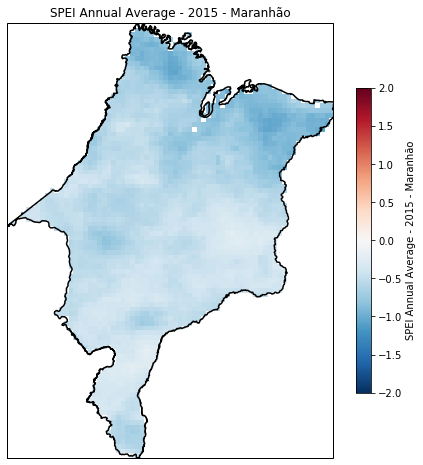

In [114]:
######################################################################
        
import rasterio
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd

# Raster
src = rasterio.open("Smap_2015_fixed_clipped.tif")
D = src.read(1)

# Extent
bounds = src.bounds
extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

# Shapefile
shp = gpd.read_file("maranhao_fixed.shp")

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())

D = D.astype(float)
D[D == 0] = np.nan

im = ax.imshow(
    D,
    extent=extent,
    cmap="RdBu_r",
    origin="upper",
    transform=ccrs.PlateCarree(),
    vmin=-2,  
    vmax=2    
)

# Boundary
for geom in shp.geometry:
    ax.add_geometries(
        [geom],
        crs=ccrs.PlateCarree(),
        facecolor='none',
        edgecolor='black',
        linewidth=1.5
    )

plt.colorbar(im, ax=ax, shrink=0.7, label="SPEI Annual Average - 2015 - Maranhão")
ax.set_title("SPEI Annual Average - 2015 - Maranhão")
plt.show()        
        

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less


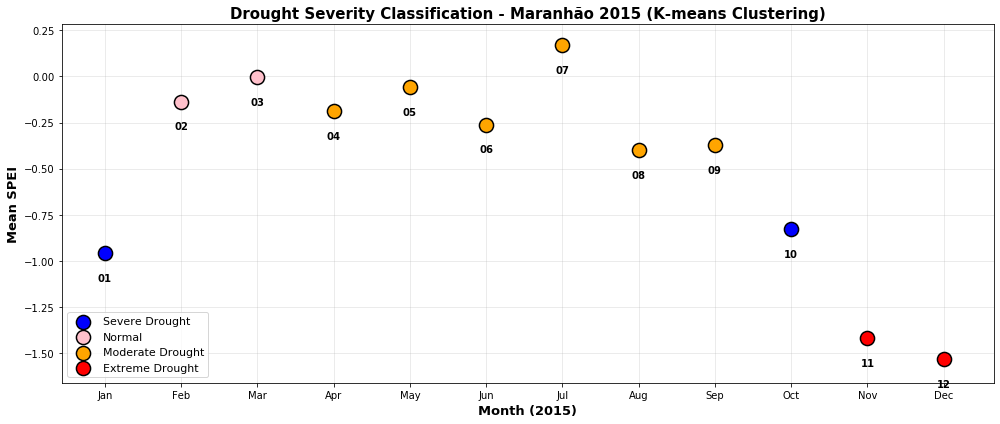

In [139]:
#########################################################################3.	K-means Clustering of Drought Severity during the 2015 Drought Event


import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

######################################################################
# Extract 2015 data

# Select only SPEI data from year 2015
spei_2015 = spei1_emp.sel(valid_time='2015')
######################################################################
# Statistics for each month

months_list = []
features_list = []

# SPEI for each month
for month_idx in range(spei_2015.shape[0]):
    spei_month = spei_2015.isel(valid_time=month_idx).values
    
    # miss values 
    valid_pixels = np.isfinite(spei_month).sum()
    if valid_pixels < 100:
        
        continue
    
# Calculate spatial statistics for this month
    mean_spei = np.nanmean(spei_month)
    min_spei = np.nanmin(spei_month)
    p10_spei = np.nanpercentile(spei_month, 10)  # 10th percentile 
    p25_spei = np.nanpercentile(spei_month, 25)  # 25th percentile
    std_spei = np.nanstd(spei_month)              # spatial variability standard deviation
    
# Calculate percentage of area in drought
    severe_drought_pixels = (spei_month < -1.5).sum()
    moderate_drought_pixels = (spei_month < -1.0).sum()
    
    pct_severe = (severe_drought_pixels / valid_pixels) * 100
    pct_moderate = (moderate_drought_pixels / valid_pixels) * 100
    
# Store all features for this month
    month_features = [
        mean_spei,      # Overall drought intensity
        min_spei,       # Worst local drought
        p10_spei,       # Dry extreme
        p25_spei,       # Lower quartile
        std_spei,       # Spatial heterogeneity
        pct_severe,     # % area in severe drought (SPEI < -1.5)
        pct_moderate    # % area in moderate drought (SPEI < -1.0)
    ]
    
    features_list.append(month_features)
    months_list.append(spei_2015.valid_time.isel(valid_time=month_idx).values)

# Convert to arrays
X_features = np.array(features_list)
dates = np.array(months_list)



######################################################################
#K maeans

# Group months into 4 drought severity categories
n_clusters = 4

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)


######################################################################


severity_names = {}
for rank, cluster_id in enumerate(cluster_order):
    if rank == 0:
        severity_names[cluster_id] = "Extreme Drought"
    elif rank == 1:
        severity_names[cluster_id] = "Severe Drought"
    elif rank == 2:
        severity_names[cluster_id] = "Moderate Drought"
    else:
        severity_names[cluster_id] = "Normal"

results_df['Severity'] = results_df['Cluster'].map(severity_names)


######################################################################
#  RESULTS

# Color scheme for each severity level
severity_colors = {"Extreme Drought": "Red",     "Severe Drought": "Blue",    "Moderate Drought": "Orange",   "Normal": "Pink" }

# Create figure
fig, ax = plt.subplots(figsize=(14, 6))

# Plot each month as a colored point
month_numbers = np.arange(1, 13)

for i, (month, severity, mean_spei) in enumerate(zip(
    results_df['Month'], 
    results_df['Severity'],
    results_df['Mean_SPEI']
)):
    
    
# Plot point with color based on severity
    add_to_legend = severity not in ax.get_legend_handles_labels()[1]
    
    ax.scatter(i+1, mean_spei, c=severity_colors[severity],   s=200, label=severity if add_to_legend else "",edgecolor='black', linewidth=1.5, zorder=3)
    
# Add month number as text label
    ax.text(i+1, mean_spei-0.15, month[-2:],  ha='center', fontsize=10, fontweight='bold')



ax.set_xlabel('Month (2015)', fontsize=13, fontweight='bold')
ax.set_ylabel('Mean SPEI', fontsize=13, fontweight='bold')
ax.set_title('Drought Severity Classification - Maranhão 2015 (K-means Clustering)',  fontsize=15, fontweight='bold')
ax.set_xticks(month_numbers)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.grid(alpha=0.3)
ax.legend(loc='lower left', fontsize=11)

plt.tight_layout()
plt.show()


In [29]:
###############################################################################
########################## RANDOM FOREST BETWEEN MODELS

########################## RANDOM FOREST BETWEEN MODELS USIGN LAND COVER  AS DEFORESTATION

import numpy as np
import rasterio
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Raster SPEI
src_spei= rasterio.open("Smap_2015_fixed_clipped.tif")
SPEI  = src_spei.read(1)


# Raster NVDI
src_ndvi = rasterio.open("NDVI_rainy_anomaly_2015.tif")
NDVI  = src_ndvi.read(1)

# Raster DEFORESTATION
src_defor= rasterio.open("MCD12Q1_Maranhao_2015_masked_multiclass.tif")
Defor  = src_defor.read(1)

print(NDVI.shape)
print(Defor.shape)
print(SPEI.shape)

print("SPEI:", src_spei.shape, src_spei.bounds)
print("NDVI:", src_ndvi.shape, src_ndvi.bounds)
print("Defor:", src_defor.shape, src_defor.bounds)

###################



(4577, 3768)
(2052, 1550)
(92, 69)
SPEI: (92, 69) BoundingBox(left=-48.75, bottom=-10.25, right=-41.849999999999994, top=-1.0500000000000007)
NDVI: (4577, 3768) BoundingBox(left=-49.332986364548155, bottom=-10.262723137978742, right=-41.74692763955751, top=-1.0479166665662776)
Defor: (2052, 1550) BoundingBox(left=-48.75606204558703, bottom=-10.263252121065534, right=-41.79411859366074, top=-1.0465373059992427)


In [37]:
!gdalwarp \
    -te -48.75 -10.25 -41.85 -1.05 \
    -ts 69 92 \
    -r near \
    -overwrite \
    NDVI_rainy_anomaly_2015.tif \
    NDVI_aligned.tif

Creating output file that is 69P x 92L.
Processing NDVI_rainy_anomaly_2015.tif [1/1] : 0Using internal nodata values (e.g. nan) for image NDVI_rainy_anomaly_2015.tif.
Copying nodata values from source NDVI_rainy_anomaly_2015.tif to destination NDVI_aligned.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [38]:
!gdalwarp \
    -te -48.75 -10.25 -41.85 -1.05 \
    -ts 69 92 \
    -r near \
    -overwrite \
    MCD12Q1_Maranhao_2015_masked_multiclass.tif \
    Defor_aligned_Final.tif

Creating output file that is 69P x 92L.
Processing MCD12Q1_Maranhao_2015_masked_multiclass.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [9]:
!cp Smap_2015_fixed_clipped.tif SPEI_aligned.tif

In [39]:
src_spei = rasterio.open("SPEI_aligned.tif")
src_ndvi = rasterio.open("NDVI_aligned.tif")
src_defor = rasterio.open("Defor_aligned_Final.tif")

print(f"\nSPEI:  {src_spei.shape}  {src_spei.bounds}")
print(f"NDVI:  {src_ndvi.shape}  {src_ndvi.bounds}")
print(f"Defor: {src_defor.shape}  {src_defor.bounds}")


SPEI:  (92, 69)  BoundingBox(left=-48.75, bottom=-10.25, right=-41.849999999999994, top=-1.0500000000000007)
NDVI:  (92, 69)  BoundingBox(left=-48.75, bottom=-10.25, right=-41.85, top=-1.05)
Defor: (92, 69)  BoundingBox(left=-48.75, bottom=-10.25, right=-41.85, top=-1.05)


In [40]:
import numpy as np
import rasterio
import sklearn.model_selection
import sklearn.ensemble
import matplotlib.pyplot as plt
import pandas as pd

# Load rasters
src_spei = rasterio.open("SPEI_aligned.tif")
SPEI = src_spei.read(1).astype(float)
SPEI[SPEI == 0] = np.nan

src_ndvi = rasterio.open("NDVI_aligned.tif")
NDVI = src_ndvi.read(1).astype(float)
NDVI[NDVI == 0] = np.nan

src_defor = rasterio.open("Defor_aligned_Final.tif")
Defor = src_defor.read(1).astype(float)
Defor[Defor == 0] = np.nan

print(f"SPEI: {SPEI.shape}")
print(f"NDVI: {NDVI.shape}")
print(f"Defor: {Defor.shape}")

# Flatten to 1D
spei_flat = SPEI.flatten()
ndvi_flat = NDVI.flatten()
defor_flat = Defor.flatten()

# Stack features: NDVI and SPEI predict Deforestation
predictor_vars = ["NDVI", "SPEI"]
X = np.column_stack([ndvi_flat, spei_flat])
y = defor_flat

# Remove NaNs for training
mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
X_train = X[mask]
y_train = y[mask]


######################################################################
#RANDOM FOREST


kf = sklearn.model_selection.KFold(n_splits=10, shuffle=True, random_state=1)
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100, random_state=1, max_depth=15)


scores = sklearn.model_selection.cross_val_score(rf, X_train, y_train, cv=kf)
rf.fit(X_train, y_train)

print(f"  Cross-validation mean score: {np.mean(scores):.3f}")


SPEI: (92, 69)
NDVI: (92, 69)
Defor: (92, 69)
  Cross-validation mean score: 0.568


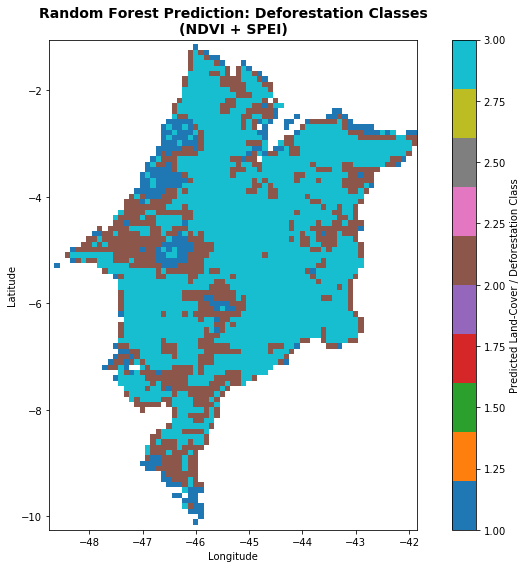

In [41]:
y_pred = rf.predict(X_train)
map_pred = np.full(defor_flat.shape, np.nan)
map_pred[mask] = y_pred

map_pred = map_pred.reshape(Defor.shape)
bounds = src_defor.bounds
extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
plt.figure(figsize=(10, 8))

plt.imshow(
    map_pred,
    extent=extent,
    origin="upper",
    cmap="tab10"
)

plt.title("Random Forest Prediction: Deforestation Classes\n(NDVI + SPEI)", fontsize=14, fontweight="bold")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

cbar = plt.colorbar()
cbar.set_label("Predicted Land-Cover / Deforestation Class")

plt.tight_layout()
plt.show()

In [36]:
###############################################################################
########################## Pearson correlation between variables
from scipy.stats import pearsonr

spei_valid=spei_flat[mask]
ndvi_valid=ndvi_flat[mask]

r, p = pearsonr(spei_valid, ndvi_valid)

print(f"Pearson r = {r:.3f}")
print(f"p-value   = {p:.3e}")



Pearson r = -0.182
p-value   = 1.054e-20


In [42]:
###############################################################################
########################## RANDOM FOREST BETWEEN MODELS USIGN FOREST AS DEFORESTATION

import numpy as np
import rasterio
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Raster SPEI
src_spei= rasterio.open("Smap_2015_fixed_clipped.tif")
SPEI  = src_spei.read(1)


# Raster NVDI
src_ndvi = rasterio.open("NDVI_rainy_anomaly_2015.tif")
NDVI  = src_ndvi.read(1)

# Raster DEFORESTATION
src_defor= rasterio.open("MCD12Q1_Maranhao_2015_masked_multiclass.tif")
Defor  = src_defor.read(1)

print(NDVI.shape)
print(Defor.shape)
print(SPEI.shape)

print("SPEI:", src_spei.shape, src_spei.bounds)
print("NDVI:", src_ndvi.shape, src_ndvi.bounds)
print("Defor:", src_defor.shape, src_defor.bounds)

###################


(4577, 3768)
(2052, 1550)
(92, 69)
SPEI: (92, 69) BoundingBox(left=-48.75, bottom=-10.25, right=-41.849999999999994, top=-1.0500000000000007)
NDVI: (4577, 3768) BoundingBox(left=-49.332986364548155, bottom=-10.262723137978742, right=-41.74692763955751, top=-1.0479166665662776)
Defor: (2052, 1550) BoundingBox(left=-48.75606204558703, bottom=-10.263252121065534, right=-41.79411859366074, top=-1.0465373059992427)


In [43]:
!gdalwarp \
    -te -48.75 -10.25 -41.85 -1.05 \
    -ts 69 92 \
    -r near \
    -overwrite \
    MCD12Q1_Maranhao_2015_masked_forest.tif \
    Defor_aligned_Final_2.tif

Creating output file that is 69P x 92L.
Processing MCD12Q1_Maranhao_2015_masked_forest.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [45]:
import numpy as np
import rasterio
import sklearn.model_selection
import sklearn.ensemble
import matplotlib.pyplot as plt
import pandas as pd

# Load rasters
src_spei = rasterio.open("SPEI_aligned.tif")
SPEI = src_spei.read(1).astype(float)
SPEI[SPEI == 0] = np.nan

src_ndvi = rasterio.open("NDVI_aligned.tif")
NDVI = src_ndvi.read(1).astype(float)
NDVI[NDVI == 0] = np.nan

src_defor = rasterio.open("Defor_aligned_Final_2.tif")
Defor = src_defor.read(1).astype(float)
Defor[Defor == 0] = np.nan

print(f"SPEI: {SPEI.shape}")
print(f"NDVI: {NDVI.shape}")
print(f"Defor: {Defor.shape}")

# Flatten to 1D
spei_flat = SPEI.flatten()
ndvi_flat = NDVI.flatten()
defor_flat = Defor.flatten()

# Stack features: NDVI and SPEI predict Deforestation
predictor_vars = ["NDVI", "SPEI"]
X = np.column_stack([ndvi_flat, spei_flat])
y = defor_flat

# Remove NaNs for training
mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
X_train = X[mask]
y_train = y[mask]


######################################################################
#RANDOM FOREST


kf = sklearn.model_selection.KFold(n_splits=10, shuffle=True, random_state=1)
rf = sklearn.ensemble.RandomForestRegressor(n_estimators=100, random_state=1, max_depth=15)


scores = sklearn.model_selection.cross_val_score(rf, X_train, y_train, cv=kf)
rf.fit(X_train, y_train)

print(f"  Cross-validation mean score: {np.mean(scores):.3f}")


SPEI: (92, 69)
NDVI: (92, 69)
Defor: (92, 69)
  Cross-validation mean score: 1.000


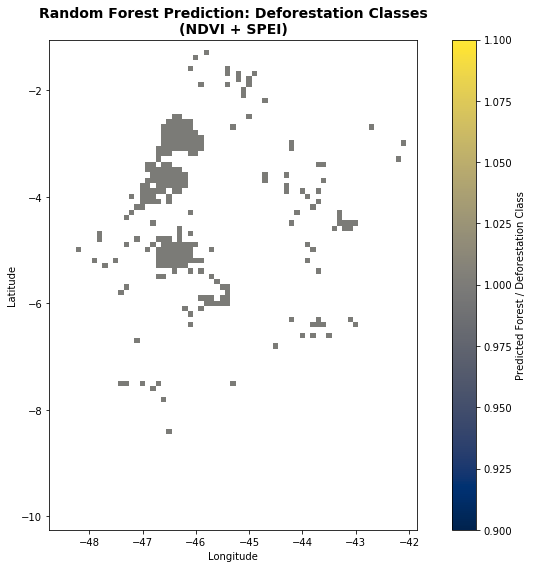

In [48]:
y_pred = rf.predict(X_train)
map_pred = np.full(defor_flat.shape, np.nan)
map_pred[mask] = y_pred

map_pred = map_pred.reshape(Defor.shape)
bounds = src_defor.bounds
extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
plt.figure(figsize=(10, 8))

plt.imshow(
    map_pred,
    extent=extent,
    origin="upper",
    cmap="cividis"
)

plt.title("Random Forest Prediction: Deforestation Classes\n(NDVI + SPEI)", fontsize=14, fontweight="bold")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

cbar = plt.colorbar()
cbar.set_label("Predicted Forest / Deforestation Class")

plt.tight_layout()
plt.show()

In [50]:
from scipy.stats import pearsonr

spei_valid=spei_flat[mask]
ndvi_valid=ndvi_flat[mask]
defor_valid=defor_flat[mask]


r, p = pearsonr(spei_valid, ndvi_valid)


print(f"Pearson r = {r:.3f}")
print(f"p-value   = {p:.3e}")


Pearson r = -0.166
p-value   = 7.701e-03


In [56]:
defor_valid
print(spei_valid)

[-0.78698415 -0.8939572  -0.883044   -0.86030382 -0.92414361 -0.9195227
 -0.82290292 -0.99687582 -0.87541366 -0.88990372 -0.96583509 -0.89182276
 -1.00130236 -0.98079997 -0.78446293 -0.689174   -0.64387918 -0.7125842
 -0.68847609 -0.63939381 -0.62709838 -0.58425814 -0.57197851 -0.55361873
 -0.57867199 -0.60971636 -0.61091858 -0.57611996 -0.52693892 -0.54183763
 -0.59319091 -0.57796669 -0.58555335 -0.56570756 -0.59743667 -0.55379075
 -0.53676921 -0.54091382 -0.54515117 -0.56258869 -0.55604815 -0.54341704
 -0.51875281 -0.51926291 -0.55143052 -0.57169217 -0.60282177 -0.57111186
 -0.51277125 -0.53799981 -0.51403314 -0.55618745 -0.59084362 -0.59026724
 -0.79982257 -0.88534641 -0.5858323  -0.60672826 -0.50660253 -0.48401186
 -0.4959594  -0.4623675  -0.48372698 -0.555314   -0.51512384 -0.81378245
 -0.56557411 -0.53868026 -0.46256492 -0.44400597 -0.48041701 -0.60229617
 -0.99275708 -0.67110258 -0.6061399  -0.53757548 -0.55647939 -0.75850326
 -0.84879559 -0.73435968 -0.65747547 -0.55347329 -0.5

In [57]:
from scipy.stats import pearsonr

spei_valid=spei_flat[mask]
ndvi_valid=ndvi_flat[mask]
defor_valid=defor_flat[mask]


r, p = pearsonr(spei_valid, defor_valid)


print(f"Pearson r = {r:.3f}")
print(f"p-value   = {p:.3e}")

Pearson r = nan
p-value   = nan
